# Release Notes

    这个部分就作为版本记录吧。记录这个版本来自于哪一个版本。 

上一个版本：3.10-FeatureEngineering-MyFEPlan-1128。

相对于上一个版本的重大改动：删掉了后面部分没用的代码。如果想取回，参见上一个版本。

更早版本记录：3.8.1系列。





# Setting working directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

# Importing libraries and load datasets

In [2]:
## 安装catboost和lightgbm。
## catboost耗费显存极大，但是飞快；lightgbm好像不是那么的方便，gpu使用不起来。
!pip install catboost
# !pip uninstall lightgbm
# !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

     |████████████████████████████████| 66.3MB 81kB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
# import tqdm
warnings.filterwarnings('ignore')

In [4]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl')

# Starting feature engineering

## Load dataset

In [ ]:
data_train = pd.read_csv('originalDataset/train.csv')
data_test_a = pd.read_csv('originalDataset/testA.csv')

## Numerical features and category features

In [ ]:
# numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
# category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
# label = 'isDefault'
# numerical_fea.remove(label)

In [ ]:
# category_fea

In [ ]:
# #过滤数值型类别特征
# def get_numerical_serial_fea(data,feas):
#     numerical_serial_fea = []
#     numerical_noserial_fea = []
#     for fea in feas:
#         temp = data[fea].nunique()
#         if temp <= 10:
#             numerical_noserial_fea.append(fea)
#             continue
#         numerical_serial_fea.append(fea)
#     return numerical_serial_fea,numerical_noserial_fea
# numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)

In [ ]:
# numerical_fea

In [ ]:
# numerical_noserial_fea

In [ ]:
# category_fea

## Classify the features into multiple categories

In [ ]:
total_list = sorted(list(data_train.columns))

In [5]:
numerical_category_fewValues = [
    "homeOwnership", 
    "verificationStatus",
    "initialListStatus",
    "applicationType",
    "n11",
    "n12",
]

In [6]:
numerical_category_manyValues = [
    "regionCode",
    "employmentTitle",
    "purpose",
    "postCode",
    "title",
]

In [7]:
date_type = [
    "issueDate", 
    "earliesCreditLine"
]

In [8]:
numerical_serial = [
    "loanAmnt","interestRate","installment","annualIncome","dti","delinquency_2years","ficoRangeLow","ficoRangeHigh","openAcc",
    "pubRec","pubRecBankruptcies","revolBal","revolUtil","totalAcc","n0","n1","n2","n3",
    "n4","n5","n6","n7","n8","n9","n10","n13","n14",
    "term", 
]

In [9]:
object_serial = [
    "grade",
    "subGrade", 
    "employmentLength"
]

In [10]:
# len(numerical_category_fewValues) + len(numerical_category_manyValues) + len(date_type) + len(numerical_serial) + len(object_serial)
new_cates = numerical_category_fewValues + numerical_category_manyValues + date_type + numerical_serial + object_serial

In [ ]:
set(total_list) - set(new_cates)

{'id', 'isDefault', 'policyCode'}

In [ ]:
# data_train = data_train.head(200)
# data_test_a = data_test_a.head(200)

## Fill the null. 

**Mind this**: Some other filling schemes can be used. 

In [ ]:
# data_train.isnull().sum()

In [ ]:
# data_train["n14"].head()

In [ ]:
## Change the infinite number into NaN. 
# data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# data_test_a.replace([np.inf, -np.inf], np.nan, inplace=True)

Lagrange interpolation

In [ ]:
# 创建函数，做插值，以空值前后5个数据（共10个数据）为例做插值  
from scipy.interpolate import lagrange  

## https://www.programmersought.com/article/37145216331/
def fillNanWithLagr(col,nv=-1,k=3):
    # col "fill column vector", nv "empty value, default -1", k "Lagrangian interval, default 3"
    # Get the null position
    if nv is np.nan:
        tar = col[col.isnull()].index.tolist()
    else:
        tar = col[col==nv].index.tolist()

    for idx in tqdm.tqdm(tar, position=0, leave=True):
      ## you can also use tqdm.tqdm_notebook(). The graphic info is more beautiful. 
    # for idx in tqdm.tqdm(tar):
                # Get Lagrange interval
                # The empty value position is removed here, because the filled empty value cannot be used to calculate other empty values
        # print(idx, end="")
        rel = col.iloc[
            list(
                set(list(range(idx-k,idx))+list(range(idx+1,idx+k+1))).difference(set(tar))
            )
        ]
                # Keep a reasonable range
        rel = rel[rel>=0][rel<len(col)]
                # Fill in Lagrangian mean
        # lagrange(arg1,arg2)(arg3)
                # arg1 "Iterable object index", arg2 "Iterable object conversion table", arg3 "Fill position"
        col.iloc[idx] = lagrange(rel.index,list(rel))(idx)
    return col

In [ ]:
# # data_train_cp = data_train.copy()
# # data_test_a_cp = data_test_a.copy()

# for i, data in enumerate([data_train, data_test_a]):
#     print("in the {} dataset:".format(i + 1))
#     for fea in numerical_fea:
#         if fea == "id":
#             continue
#         print(fea)
#         data[fea] = fillNanWithLagr(data[fea], np.nan, 5)

In [ ]:
# data_train.to_csv("preprocessedData/lagrangeInterpolated_train.csv", index=False)
# data_test_a.to_csv("preprocessedData/lagrangeInterpolated_test.csv", index=False)

Median interpolation

In [ ]:
# #按照平均数填充数值型特征
# data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
# data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())
# #按照众数填充类别型特征
# data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
# data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

`employmentLength` cannot be filled by `mode()`. I don't know why. 

In [ ]:
# data_train.info()

In [ ]:
# data_train = data_train.fillna(axis = 0, method = "ffill")

### Scheme A

No filling

In [ ]:
## No filling of any null value

### Scheme B

Fill for the first round.

In [ ]:
for fea in numerical_serial:
    #按照平均数填充数值型特征
    data_train[fea] = data_train[fea].fillna(data_train[fea].median())
    data_test_a[fea] = data_test_a[fea].fillna(data_train[fea].median())

for fea in numerical_category_fewValues + numerical_category_manyValues + object_serial + date_type:
    #按照众数填充类别型特征
    data_train[fea] = data_train[fea].fillna(data_train[fea].mode())
    data_test_a[fea] = data_test_a[fea].fillna(data_train[fea].mode())

## Change `object_serial` 


### Scheme A

Change the `subGrade`, `grade`, `employmentLength`

In [ ]:
for col in tqdm.tqdm(['subGrade', 'grade']): #, 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


In [ ]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [ ]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0]) ## mind this. use the int type in np, not general python int. 
    
for data in [data_train, data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [ ]:
data_train["employmentLength"].head()

0     2.0
1     5.0
2     8.0
3    10.0
4     NaN
Name: employmentLength, dtype: float64

In [ ]:
## `employmentLength` can be filled by `mean()`. Great.
# data_train['employmentLength'].fillna(data_train["employmentLength"].mean(), inplace = True)
# data_test_a['employmentLength'].fillna(data_test_a["employmentLength"].mean(), inplace = True)
# data_train.info()

## Change `date_type` 


### Scheme A

In [ ]:
#转化成时间格式
for data in [data_train, data_test_a]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['issueYear'] = data['issueDate'].apply(lambda x: int(x.split("-")[0]))
    data['issueMonth'] = data['issueDate'].apply(lambda x: int(x.split("-")[1]))

In [ ]:
#转化成时间格式
def monthMapping(monthStr):
    dic = {
        "Jan": 1, 
        "Feb": 2, 
        "Mar": 3,
        "Apr": 4,
        "May": 5, 
        "Jun": 6, 
        "Jul": 7, 
        "Aug": 8, 
        "Sep": 9,
        "Oct": 10, 
        "Nov": 11,
        "Dec": 12
    }
    return dic[monthStr]

for data in [data_train, data_test_a]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['earliesCreditLineYear'] = data['earliesCreditLine'].apply(lambda x: int(x.split("-")[1]))
    data['earliesCreditLineMonth'] = data['earliesCreditLine'].apply(lambda x: monthMapping(x.split("-")[0]))

In [ ]:
#转化成时间格式
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [ ]:
startmonth = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train, data_test_a]:
    data["earliesCreditLine"] = data["earliesCreditLine"].apply(lambda x: datetime.datetime.strptime(x, '%b-%Y'))
    data["earliesCreditLineDT"] = data["earliesCreditLine"].apply(lambda x: x-startdate).dt.days

In [11]:
date_type += [
    "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
    "issueYear", "issueMonth"
]
date_type

['issueDate',
 'earliesCreditLine',
 'issueDateDT',
 'earliesCreditLineDT',
 'earliesCreditLineYear',
 'earliesCreditLineMonth',
 'issueYear',
 'issueMonth']

In [ ]:
# data_train.to_csv("preprocessedData/data_train-1222-b_a_a.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1222-b_a_a.csv", index=False)

In [ ]:
data_train = pd.read_csv("preprocessedData/data_train-1222-b_a_a.csv")
data_test_a = pd.read_csv("preprocessedData/data_test_a-1222-b_a_a.csv")

## Change `numerical_serial` 


In [ ]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [ ]:
data_train_cp = data_train.copy()
feaList = []
numList = []
for fea in numerical_serial:
    # if fea in ['homeOwnership', 'verificationStatus', "applicationType", "initialListStatus", "policyCode"]:
    #     continue
    data_train_cp = find_outliers_by_3segama(data_train_cp,fea)
    valCount = data_train_cp[fea+'_outliers'].value_counts()
    abnormalRate = 1-valCount["正常值"] / len(data_train_cp)
    if abnormalRate > 0.00001:
        feaList.append(fea)
        numList.append(abnormalRate)
        # print(valCount, "\n") ## 获得正常值和异常值的数量
        # print(1-valCount["正常值"] / len(data_train_cp), "\n") ## 获得正常值和异常值的数量
        # print(data_train_cp.groupby(fea+'_outliers')['isDefault'].sum(), "\n") ## 获得异常值和正常值里面有多少个正例
        # print('*'*100)

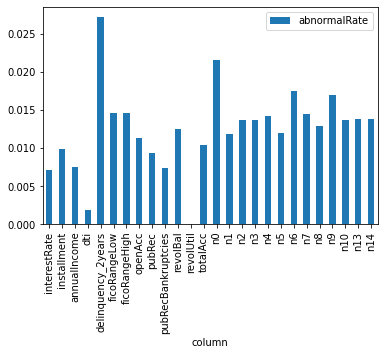

In [ ]:
tmpPd = pd.DataFrame({
    "column": feaList, 
    "abnormalRate": numList,
})
tmpPd.set_index(["column"], inplace=True)
tmpPd.plot(kind='bar')

In [ ]:
import numpy as np
from scipy.stats import chi
import pandas as pd
from pandas import DataFrame,Series
import scipy

def chi3(arr):
    '''
    计算卡方值
    arr:频数统计表,二维numpy数组。
    '''
    assert(arr.ndim==2)
    #计算每行总频数
    R_N = arr.sum(axis=1)
    #每列总频数
    C_N = arr.sum(axis=0)
    #总频数
    N = arr.sum()
    # 计算期望频数 C_i * R_j / N。
    E = np.ones(arr.shape)* C_N / N
    E = (E.T * R_N).T
    square = (arr-E)**2 / E
    #期望频数为0时，做除数没有意义，不计入卡方值
    square[E==0] = 0
    #卡方值
    v = square.sum()
    return v

def chiMerge(df,col,target,max_groups=None,threshold=None):

    '''
    卡方分箱
    df: pandas dataframe数据集
    col: 需要分箱的变量名（数值型）
    target: 类标签
    max_groups: 最大分组数。
    threshold: 卡方阈值，如果未指定max_groups，默认使用置信度95%设置threshold。
    return: 包括各组的起始值的列表.
    '''

    freq_tab = pd.crosstab(df[col],df[target])

    #转成numpy数组用于计算。
    freq = freq_tab.values

    #初始分组切分点，每个变量值都是切分点。每组中只包含一个变量值.

    #分组区间是左闭右开的，如cutoffs = [1,2,3]，则表示区间 [1,2) , [2,3) ,[3,3+)。
    cutoffs = freq_tab.index.values

    #如果没有指定最大分组
    if max_groups is None:    
        #如果没有指定卡方阈值，就以95%的置信度（自由度为类数目-1）设定阈值。
        if threshold is None:
            #类数目
            cls_num = freq.shape[-1]
            threshold = chi2.isf(0.05,df= cls_num - 1)

    while True:
        minvalue = None
        minidx = None
        #从第1组开始，依次取两组计算卡方值，并判断是否小于当前最小的卡方
        for i in range(len(freq) - 1):
            v = chi3(freq[i:i+2])
            if minvalue is None or (minvalue > v): #小于当前最小卡方，更新最小值
                minvalue = v
                minidx = i

        #如果最小卡方值小于阈值，则合并最小卡方值的相邻两组，并继续循环
        if  (max_groups is not None and  max_groups< len(freq) ) or (threshold is not None and minvalue < threshold):
            #minidx后一行合并到minidx
            tmp  = freq[minidx] + freq[minidx+1]
            freq[minidx] = tmp
            #删除minidx后一行
            freq = np.delete(freq,minidx+1,0)
            #删除对应的切分点
            cutoffs = np.delete(cutoffs,minidx+1,0)

        else: #最小卡方值不小于阈值，停止合并。
            break
    return cutoffs

def value2group(x,cutoffs):

    '''
    将变量的值转换成相应的组。
    x: 需要转换到分组的值
    cutoffs: 各组的起始值。
    return: x对应的组，如group1。从group1开始。
    '''

    #切分点从小到大排序。
    cutoffs = sorted(cutoffs)
    num_groups = len(cutoffs)

    #异常情况：小于第一组的起始值。这里直接放到第一组。
    #异常值建议在分组之前先处理妥善。
    if x < cutoffs[0]:
        return 1 #'group1'

    for i in range(1,num_groups):
        if cutoffs[i-1] <= x < cutoffs[i]:
            return i # 'group{}'.format(i)

    #最后一组，也可能会包括一些非常大的异常值。
    return num_groups #'group{}'.format(num_groups)

def calWOE(df ,var ,target):

    '''
    计算WOE编码
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：编码字典
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    return gbri['woe'].to_dict()

def calIV(df,var,target):

    '''
    计算IV值
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：IV值
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    gbri['iv'] = (gbri[1] - gbri[0])*gbri['woe']
    return gbri['iv'].sum()

### Scheme A

See abnormal values. Bin the columns that having many abnormal values. 我们仅查看异常值率大于0.015的。

`delinquency_2years, n0, n6` having abnormal values more than 1.5\%. 

In [ ]:
for fea in ["n0", "n6", "delinquency_2years"]:
    print("for feature: {}...".format(fea))
    cutoffs = chiMerge(data_train, fea,'isDefault',max_groups=10)
    data_train[fea] = data_train[fea].apply(value2group,args=(cutoffs,))
    data_test_a[fea] = data_test_a[fea].apply(value2group,args=(cutoffs,))

for feature: n0...
for feature: n6...
for feature: delinquency_2years...


### Scheme B

对全部的有异常值的列进行分箱

In [ ]:
for fea in tqdm.tqdm(feaList):
          # [
          #   'interestRate',
          #   #'installment', #
          #   #'annualIncome',#
          #   #'dti', #
          #   'delinquency_2years',
          #   'ficoRangeLow',
          #   'ficoRangeHigh',
          #   'openAcc',
          #   'pubRec',
          #   'pubRecBankruptcies',
          #   #'revolBal', #
          #   'revolUtil',
          #   'totalAcc',
          #   'n0',
          #   'n1',
          #   'n2',
          #   'n3',
          #   'n4',
          #   'n5',
          #   'n6',
          #   'n7',
          #   'n8',
          #   'n9',
          #   'n10',
          #   'n13',
          #   'n14'
          #   ]:
    print("for feature: {}...".format(fea))
    cutoffs = chiMerge(data_train, fea,'isDefault',max_groups=10)
    data_train[fea] = data_train[fea].apply(value2group,args=(cutoffs,))
    data_test_a[fea] = data_test_a[fea].apply(value2group,args=(cutoffs,))

  0%|          | 0/26 [00:00<?, ?it/s]

for feature: interestRate...


  4%|▍         | 1/26 [00:11<04:41, 11.28s/it]

for feature: installment...


KeyboardInterrupt: ignored

## Change `numerical_category_fewValues` 


### Scheme A

numerical_category_fewValues 被dummy了。

In [ ]:
data_train = pd.get_dummies(data_train, columns=numerical_category_fewValues, drop_first=True)
data_test_a = pd.get_dummies(data_test_a, columns=numerical_category_fewValues, drop_first=True)


In [ ]:
# data[["n11", "n12"]].head()
# for data in [data_train, data_test_a]:
#     data[["n11", "n12"]] = data[["n11", "n12"]].astype(int)

### Scheme B

不使用 dummy

In [ ]:
## Nothing is done. 

## Change `numerical_category_manyValues` 


###  Scheme A

不做处理

In [ ]:
## Nothing is done

## Feature Generation

利用 https://zhuanlan.zhihu.com/p/26444240 介绍的方法开展特征合成：

```
median(N1)_by(C1)  \\ 中位数
mean(N1)_by(C1)  \\ 算术平均数
mode(N1)_by(C1)  \\ 众数
min(N1)_by(C1)  \\ 最小值
max(N1)_by(C1)  \\ 最大值
std(N1)_by(C1)  \\ 标准差
var(N1)_by(C1)  \\ 方差
freq(C2)_by(C1)  \\ 频数

freq(C1) \\这个不需要groupby也有意义
```

In [ ]:
# data_train.to_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv", index=False)

In [ ]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv")

In [ ]:
# ####
# ## 这个适用于A-F。
# ##
# ####

# from sklearn.feature_selection import SelectKBest
# from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

# def selectNFeatures(numSelectedFeatures, data_train, y_train, fillMethod = "ffill"):
#     ## 到时候，就指着返回下面两个表了
#     selectedFeatures = []
#     deletedFeatures = []

#     ## 无脑处理：将所有的正负无穷都处理掉。
#     data_train = data_train.replace([np.inf, -np.inf], np.nan)
#     ## 填充方法
#     if fillMethod in ["ffill", "bfill"]:
#         data_train = data_train.fillna(axis = 1, method = fillMethod) # "ffill"
#     else: 
#         data_train = data_train.fillna(data_train.median())  

#     ## columnsThatHaveNullVal 这些列，终究是有空值的，那就放弃他们吧。
#     tmpList = data_train.isnull().sum().to_frame('nulls')
#     columnsThatHaveNullVal = list(tmpList[tmpList["nulls"] > 0].index)
#     deletedFeatures.extend(columnsThatHaveNullVal)
#     data_train.drop(columnsThatHaveNullVal, axis = 1, inplace=True)

#     # print(data_train.isnull().sum())
#     # print()
#     # print(y_train.isnull().sum())
#     # print(data_train.head(20))
#     # print(np.any(np.isnan(data_train)))

#     selector = SelectKBest(k=numSelectedFeatures)
#     selector.fit(data_train, y_train)
#     colNums = selector.get_support(True)
#     # print(colNums)
#     for i, col in enumerate(list(data_train.columns)):
#         if i in colNums:
#             selectedFeatures.append(col)
#         # else: 
#         #     deletedFeatures.append(col)
#     # print(selectedFeatures, deletedFeatures)
            
#     return selectedFeatures , deletedFeatures

# def combinationOfFeatures(category, serial, method, method_name, data_train, data_test_a, n):
#     '''
#     combine and generate some new features. 

#     category: list of the categorical column names
#     serial: list of the serial column names
#     method: ["mean"], ["max"], ["min"], pd.Series.model, etc..
#     method_name: the name of the method. Must be strings. 
#     n: newly generated features, select n from them. if n == -1, then select all of the newly generated features. 
#     '''
#     # ori_cols_train = list(data_train.columns)
#     # ori_cols_test = list(data_test_a.columns)

#     new_cols = []
    
#     for col in category: 
#         for numFea in serial: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
#             # print("categorical: {}, serial: {}".format(col, numFea))
#             temp_dict = data_train.groupby([col])[numFea].agg(method).reset_index().rename(columns={method_name: col + '_{}_{}'.format(numFea, method_name)})
#             temp_dict.index = temp_dict[col].values
#             temp_dict = temp_dict[col + '_{}_{}'.format(numFea, method_name)].to_dict()
            
#             data_train[col + '_{}_{}'.format(numFea, method_name)] = data_train[col].map(temp_dict)
#             data_test_a[col + '_{}_{}'.format(numFea, method_name)] = data_test_a[col].map(temp_dict)
            
#             new_cols.append(col + '_{}_{}'.format(numFea, method_name))
    
#     if n >= 0: 
#         tmp_train = data_train[new_cols].copy()

#         selectedFeatures, deletedFeatures = selectNFeatures(n, tmp_train, data_train[["isDefault"]]) #

#         data_train.drop(deletedFeatures, axis = 1, inplace=True)
#         data_test_a.drop(deletedFeatures, axis = 1, inplace=True)
#         # data_train = data_train[ori_cols_train + selectedFeatures]
#         # data_test_a = data_test_a[ori_cols_test + selectedFeatures]

#     elif n < 0:
#         pass

#     return data_train, data_test_a

# def combinationOfFeatures_divide(feaGroup1, feaGroup2, method, df, df_test, n):
#     ori_cols_train = list(df.columns)
#     ori_cols_test = list(df_test.columns)

#     new_cols = []

#     for fea1 in feaGroup1: ## grade
#         for fea2 in feaGroup2: ## nXX
            
#             df['{}_to_{}_'.format(fea1, method) + fea2] = df[fea1] / df.groupby([fea2])[fea1].transform(method)
#             df_test['{}_to_{}_'.format(fea1, method) + fea2] = df_test[fea1] / df_test.groupby([fea2])[fea1].transform(method)
            
#             new_cols.append('{}_to_{}_'.format(fea1, method) + fea2)
#     # print(new_cols)
    
#     if n >= 0:
#         tmp_train = df[new_cols].copy()
        
#         selectedFeatures , deletedFeatures = selectNFeatures(n, tmp_train, df[["isDefault"]], "median") # 
#         # print(data_train.columns)
#         # print(data_train.)
#         # print(selectedFeatures)
        
#         df.drop(deletedFeatures, axis = 1, inplace=True)
#         df_test.drop(deletedFeatures, axis = 1, inplace=True)
#         # df = df[ori_cols_train + selectedFeatures]
#         # df_test = df_test[ori_cols_test + selectedFeatures]
    
#     elif n < 0:
#         pass

#     return df, df_test

In [ ]:
####
## 这个适用于F2及以后。
##
####
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

def selectNFeatures(numSelectedFeatures, data_train, y_train, fillMethod = "ffill"):
    ## 到时候，就指着返回下面两个表了
    selectedFeatures = []
    # deletedFeatures = []

    ## 无脑处理：将所有的正负无穷都处理掉。
    data_train = data_train.replace([np.inf, -np.inf], np.nan)
    ## 填充方法
    if fillMethod in ["ffill", "bfill"]:
        data_train = data_train.fillna(axis = 1, method = fillMethod) # "ffill"
    else: 
        for fea in data_train.columns:
            data_train[fea] = data_train[fea].fillna(data_train[fea].median())  

    ## columnsThatHaveNullVal 这些列，终究是有空值的，那就放弃他们吧。
    tmpList = data_train.isnull().sum().to_frame('nulls')
    columnsThatHaveNullVal = list(tmpList[tmpList["nulls"] > 0].index)
    # deletedFeatures.extend(columnsThatHaveNullVal)
    data_train.drop(columnsThatHaveNullVal, axis = 1, inplace=True)

    # print(data_train.isnull().sum())
    # print()
    # print(y_train.isnull().sum())
    # print(data_train.head(20))
    # print(np.any(np.isnan(data_train)))

    selector = SelectKBest(k=numSelectedFeatures)
    selector.fit(data_train, y_train)
    colNums = selector.get_support(True)
    # print(colNums)
    for i, col in enumerate(list(data_train.columns)):
        if i in colNums:
            selectedFeatures.append(col)
        # else: 
        #     deletedFeatures.append(col)
    # print(selectedFeatures, deletedFeatures)
            
    return selectedFeatures #, deletedFeatures

def combinationOfFeatures(category, serial, method, method_name, data_train, data_test_a, n):
    '''
    combine and generate some new features. 

    category: list of the categorical column names
    serial: list of the serial column names
    method: ["mean"], ["max"], ["min"], pd.Series.model, etc..
    method_name: the name of the method. Must be strings. 
    n: newly generated features, select n from them. if n == -1, then select all of the newly generated features. 
    '''
    ori_cols_train = list(data_train.columns)
    ori_cols_test = list(data_test_a.columns)

    new_cols = []
    
    for col in category: 
        for numFea in serial: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
            # print("categorical: {}, serial: {}".format(col, numFea))
            temp_dict = data_train.groupby([col])[numFea].agg(method).reset_index().rename(columns={method_name: col + '_{}_{}'.format(numFea, method_name)})
            temp_dict.index = temp_dict[col].values
            temp_dict = temp_dict[col + '_{}_{}'.format(numFea, method_name)].to_dict()
            
            data_train[col + '_{}_{}'.format(numFea, method_name)] = data_train[col].map(temp_dict)
            data_test_a[col + '_{}_{}'.format(numFea, method_name)] = data_test_a[col].map(temp_dict)
            
            new_cols.append(col + '_{}_{}'.format(numFea, method_name))
    
    if n >= 0: 
        tmp_train = data_train[new_cols].copy()

        selectedFeatures = selectNFeatures(n, tmp_train, data_train[["isDefault"]]) #, deletedFeatures

        # data_train.drop(deletedFeatures, axis = 1, inplace=True)
        # data_test_a.drop(deletedFeatures, axis = 1, inplace=True)
        data_train = data_train[ori_cols_train + selectedFeatures]
        data_test_a = data_test_a[ori_cols_test + selectedFeatures]

    elif n < 0:
        pass

    return data_train, data_test_a

def combinationOfFeatures_divide(feaGroup1, feaGroup2, method, df, df_test, n):
    ori_cols_train = list(df.columns)
    ori_cols_test = list(df_test.columns)

    new_cols = []

    for fea1 in feaGroup1: ## grade
        for fea2 in feaGroup2: ## nXX
            
            df['{}_to_{}_'.format(fea1, method) + fea2] = df[fea1] / df.groupby([fea2])[fea1].transform(method)
            df_test['{}_to_{}_'.format(fea1, method) + fea2] = df_test[fea1] / df_test.groupby([fea2])[fea1].transform(method)
            
            new_cols.append('{}_to_{}_'.format(fea1, method) + fea2)
    # print(new_cols)
    
    if n >= 0:
        tmp_train = df[new_cols].copy()
        
        selectedFeatures = selectNFeatures(n, tmp_train, df[["isDefault"]], "median") # , deletedFeatures
        # print(data_train.columns)
        # print(data_train.)
        # print(selectedFeatures)
        
        # df.drop(deletedFeatures, axis = 1, inplace=True)
        # df_test.drop(deletedFeatures, axis = 1, inplace=True)
        df = df[ori_cols_train + selectedFeatures]
        df_test = df_test[ori_cols_test + selectedFeatures]
    
    elif n < 0:
        pass

    return df, df_test

def combinationOfFeatures_multi(category, serial, methods, data_train, data_test_a, n):
    '''
    combine and generate some new features. 

    category: list of the categorical column names
    serial: list of the serial column names
    method: ["mean"], ["max"], ["min"], pd.Series.model, etc..
    method_name: the name of the method. Must be strings. 
    n: newly generated features, select n from them. if n == -1, then select all of the newly generated features. 
    '''
    ori_cols_train = list(data_train.columns)
    ori_cols_test = list(data_test_a.columns)

    new_cols = []
    
    for method in tqdm.tqdm_notebook(methods): 
        method_name = method
        for col in category: 
            for numFea in serial: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
                # print("categorical: {}, serial: {}".format(col, numFea))
                temp_dict = data_train.groupby([col])[numFea].agg([method]).reset_index().rename(columns={method_name: col + '_{}_{}'.format(numFea, method_name)})
                temp_dict.index = temp_dict[col].values
                temp_dict = temp_dict[col + '_{}_{}'.format(numFea, method_name)].to_dict()

                data_train[col + '_{}_{}'.format(numFea, method_name)] = data_train[col].map(temp_dict)
                data_test_a[col + '_{}_{}'.format(numFea, method_name)] = data_test_a[col].map(temp_dict)

                new_cols.append(col + '_{}_{}'.format(numFea, method_name))
    
    if n >= 0: 
        tmp_train = data_train[new_cols].copy()

        selectedFeatures = selectNFeatures(n, tmp_train, data_train[["label"]]) #, deletedFeatures

        # data_train.drop(deletedFeatures, axis = 1, inplace=True)
        # data_test_a.drop(deletedFeatures, axis = 1, inplace=True)
        data_train = data_train[ori_cols_train + selectedFeatures]
        data_test_a = data_test_a[ori_cols_test + selectedFeatures]

    elif n < 0:
        pass

    return data_train, data_test_a

def combinationOfFeatures_divide_multi(feaGroup1, feaGroup2, methods, df, df_test, n):
    ori_cols_train = list(df.columns)
    ori_cols_test = list(df_test.columns)

    new_cols = []
    
    for method in tqdm.tqdm_notebook(methods):
        for fea1 in feaGroup1: ## grade
            for fea2 in feaGroup2: ## nXX

                df['{}_to_{}_'.format(fea1, method) + fea2] = df[fea1] / df.groupby([fea2])[fea1].transform(method)
                df_test['{}_to_{}_'.format(fea1, method) + fea2] = df_test[fea1] / df_test.groupby([fea2])[fea1].transform(method)

                new_cols.append('{}_to_{}_'.format(fea1, method) + fea2)
        # print(new_cols)
    
    if n >= 0:
        tmp_train = df[new_cols].copy()
        
        selectedFeatures = selectNFeatures(n, tmp_train, df[["label"]], "median") # , deletedFeatures
        # print(data_train.columns)
        # print(data_train.)
        # print(selectedFeatures)
        
        # df.drop(deletedFeatures, axis = 1, inplace=True)
        # df_test.drop(deletedFeatures, axis = 1, inplace=True)
        df = df[ori_cols_train + selectedFeatures]
        df_test = df_test[ori_cols_test + selectedFeatures]
    
    elif n < 0:
        pass

    return df, df_test

### Scheme A: 

那我们着重应对的就是`numerical_category_manyValues, date_type`和`object_serial, numerical_serial`可以组合处理一下。

怎么做呢？根据C1列的取值对N1列进行分组。比如C1能取1，2，3三个值，然后根据这三个值把N1进行分组。然后获得1对应的N1分组的平均值、平均值、众数、中位数、最大值、最小值、标准差、方差、频数，然后用获得的这些值创建新的列。

取5个值？

In [ ]:
data_train.shape

(800000, 53)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
## 失败，这种方法目测是用不了的。
# data_train, data_test_a = combinationOfFeatures(
#     numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
#     object_serial + numerical_serial + ["isDefault"],
#     pd.Series.mode,
#     "mode",
#     data_train, 
#     data_test_a, 
#     5
# )

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    5
)

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in object_serial + numerical_serial + ["isDefault"]:
#         temp_dict = data_train.groupby([col])[numFea].agg(['mean']).reset_index().rename(columns={'mean': col + '_{}_mean'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_mean'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_mean'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_mean'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['max']).reset_index().rename(columns={'max': col + '_{}_max'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_max'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_max'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_max'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['min']).reset_index().rename(columns={'min': col + '_{}_min'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_min'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_min'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_min'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['std']).reset_index().rename(columns={'std': col + '_{}_std'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_std'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_std'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_std'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'annualIncome',
       'issueDate', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti',
       'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc',
       'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'earliesCreditLine', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3',
       'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14', 'issueYear',
       'issueMonth', 'earliesCreditLineYear', 'earliesCreditLineMonth',
       'issueDateDT', 'earliesCreditLineDT', 'homeOwnership_1',
       'homeOwnership_2', 'homeOwnership_3', 'homeOwnership_4',
       'homeOwnership_5', 'verificationStatus_1', 'verificationStatus_2',
       'initialListStatus_1', 'applicationType_1', 'n11_1.0', 'n11_2.0',
       'n11_3.0', 'n11_4.0', 'n12_1.0', 'n12_2.0', 'n12_3.0', 'n12_4.0',
       'employmentTitle_grade_median', 'employmentTitle

### Scheme B: 

跟A大体一样，就是新增几个列，少取几个值。

取5个值？

In [ ]:
data_train.shape

(800000, 53)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
## 失败，这种方法目测是用不了的。
# data_train, data_test_a = combinationOfFeatures(
#     numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
#     object_serial + numerical_serial + ["isDefault"],
#     pd.Series.mode,
#     "mode",
#     data_train, 
#     data_test_a, 
#     5
# )

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueYear', 'issueMonth',
       'earliesCreditLineYear', 'earliesCreditLineMonth', 'issueDateDT',
       'earliesCreditLineDT', 'employmentTitle_subGrade_median',
       'employmentTitle_isDefault_median', 'title_isDefault_median',
       'employmentTitle_subGrade_mean', 'employmentTitle_isDefault_mean',
       'title_isDefault_mean', 'employmentTitle_isDefault_max',
       't

### Scheme C

传统的方法

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

### Scheme D

在C方案的基础上，增加一点点特征，不要多，就5个。

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train.shape

### Scheme G

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    5
)

data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    5
)

### Scheme E

在D的基础上，做了一些适应于（`numerical_category_fewValues`被dummy）后的改变。

In [ ]:
numerical_category_fewValues

['homeOwnership',
 'verificationStatus',
 'initialListStatus',
 'applicationType',
 'n11',
 'n12']

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n13','n14']: # 'n11','n12',
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train.shape

(800000, 97)

### Scheme F

还没写完呢，别着急

先来两波这个啥？我也说不上来。

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade"], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "std", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade", ""], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "mean", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train.shape

(800000, 73)

再来一大波这些东西，我更是说不上来了。

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train.shape

(800000, 87)

### Scheme F1

在F的基础上再做一点调整。

先来两波这个啥？我也说不上来。

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade"], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "std", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade", ""], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "mean", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train.shape

(800000, 73)

再来一大波这些东西，我更是说不上来了。

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train.shape

(800000, 108)

### Scheme F2

在F的基础上再做一点调整。

再来一大波这些东西，我更是说不上来了。

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(800000, 58)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(800000, 63)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(800000, 68)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(800000, 78)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(800000, 83)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

(800000, 88)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(800000, 93)

In [ ]:
# data_train.to_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_f1_x.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_f1_x.csv", index=False)

上面这一波操作，已经做过，可以参考下列的中间结果。

In [ ]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_f1_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_f1_x.csv")
# data_train.shape

(800000, 93)

In [ ]:
# data_train, data_test_a = combinationOfFeatures_divide(
#     object_serial, numerical_serial
#     method, 
#     data_train,
#     data_test_a, 
#     10,
# )

In [ ]:
from itertools import combinations, permutations
hhd = map(lambda x: list(x), list(
    permutations(
        ["median", "mean", "max", "min", "std", "var", "count"],
        2
    )
))
list(hhd)

[['median', 'mean'],
 ['median', 'max'],
 ['median', 'min'],
 ['median', 'std'],
 ['median', 'var'],
 ['median', 'count'],
 ['mean', 'median'],
 ['mean', 'max'],
 ['mean', 'min'],
 ['mean', 'std'],
 ['mean', 'var'],
 ['mean', 'count'],
 ['max', 'median'],
 ['max', 'mean'],
 ['max', 'min'],
 ['max', 'std'],
 ['max', 'var'],
 ['max', 'count'],
 ['min', 'median'],
 ['min', 'mean'],
 ['min', 'max'],
 ['min', 'std'],
 ['min', 'var'],
 ['min', 'count'],
 ['std', 'median'],
 ['std', 'mean'],
 ['std', 'max'],
 ['std', 'min'],
 ['std', 'var'],
 ['std', 'count'],
 ['var', 'median'],
 ['var', 'mean'],
 ['var', 'max'],
 ['var', 'min'],
 ['var', 'std'],
 ['var', 'count'],
 ['count', 'median'],
 ['count', 'mean'],
 ['count', 'max'],
 ['count', 'min'],
 ['count', 'std'],
 ['count', 'var']]

In [ ]:
def generateDivideFeatures_combination1(data_train, data_test_a, features1, features2): 
    ### 怎么计算最后新增的特征数量？
    #### method的总数 * combinationOfFeatures_divide最后一个参数
    # for fea in tqdm.tqdm_notebook(features1):
    for method in tqdm.tqdm_notebook(['median', 'std'],): #"median", "mean", "max", "min", "std", "var", "count"
        data_train, data_test_a = combinationOfFeatures_divide(
            features1,
            features2, 
            method, 
            data_train,
            data_test_a, 
            15,
        )
    return data_train, data_test_a

In [ ]:
data_train, data_test_a = generateDivideFeatures_combination1(
    data_train, data_test_a, 
    object_serial, numerical_serial
)
data_train.shape

(800000, 153)

-----------------------------

先来几波这个啥？我也说不上来。

In [ ]:
# from itertools import combinations, permutations
# hhd = map(lambda x: list(x), list(
#     permutations(
#         ["median", "mean", "max", "min", "std", "var", "count"],
#         2
#     )
# ))
# list(hhd)

In [ ]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv")
# data_train.shape

In [ ]:
def generateDivideFeatures_combination(data_train, data_test_a, features1, features2): 
    ### 怎么计算最后新增的特征数量？
    #### len(feature1) * method的总数 * combinationOfFeatures_divide最后一个参数
    for fea in tqdm.tqdm_notebook(features1):
        for method in ['median', 'mean']: #"median", "mean", "max", "min", "std", "var", "count"
            data_train, data_test_a = combinationOfFeatures_divide(
                [fea], 
                features2, 
                method, 
                data_train,
                data_test_a, 
                10,
            )
    return data_train, data_test_a

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, numerical_serial
# )
# data_train.shape

------------------------------------

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_fewValues, numerical_category_manyValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     ["homeOwnership", "verificationStatus", "initialListStatus", "n12"], 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ]
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_fewValues, numerical_serial
# )
# data_train.shape

In [ ]:
## 失败。
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [ "applicationType", "n11", "n12"], # "verificationStatus","initialListStatus",
#     object_serial
# )
# data_train.shape

-------------------------

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_manyValues, numerical_category_fewValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_manyValues, [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ]
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_manyValues, numerical_serial
# )
# data_train.shape

In [ ]:
## 有错，暂时不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_manyValues, object_serial
# )
# data_train.shape

---------------------------------

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ], numerical_category_fewValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ], numerical_category_manyValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ], numerical_serial
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ], object_serial
# )
# data_train.shape

---------------------------

In [ ]:
## 先不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_serial, numerical_category_fewValues
# )
# data_train.shape

In [ ]:
## 先不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_serial, numerical_category_manyValues
# )
# data_train.shape

In [ ]:
## 先不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_serial, [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ]
# )
# data_train.shape

In [ ]:
## 先不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_serial, object_serial
# )
# data_train.shape

------------------------

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, numerical_category_fewValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, numerical_category_manyValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ]
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, numerical_serial
# )
# data_train.shape

--------------

In [ ]:
## 先不弄
# data_train, data_test_a = combinationOfFeatures_divide(
#     object_serial, #["grade", "subGrade"], 
#     ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
#     "std", 
#     data_train,
#     data_test_a, 
#     10,
# )

In [ ]:
## 先不弄
# data_train, data_test_a = combinationOfFeatures_divide(
#     object_serial, #["grade", "subGrade", ""], 
#     ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
#     "mean", 
#     data_train,
#     data_test_a, 
#     10,
# )

In [ ]:
# data_train.shape

(800000, 73)

## Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

### Scheme A

以后的scheme，可以考虑删掉一些被编码过的特征。但是这次，我们没删。

In [ ]:
features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
features.remove("n11_4.0")
features.remove("n12_4.0")
# data_train = data_train[(data_train["n11_4"] != 1) & (data_train["n12_4"] != 1)]
y_train = data_train['isDefault']
x_train = data_train[features]
x_test = data_test_a[features]

### Scheme B

In [ ]:
features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
y_train = data_train['isDefault']
x_train = data_train[features]
x_test = data_test_a[features]

# Save preprocessed data if necessary

In [ ]:
x_train.to_csv("preprocessedData/x_train-1222-.csv", index=False)
x_test.to_csv("preprocessedData/x_test-1222-.csv", index=False)
y_train.to_csv("preprocessedData/y_train-1222-.csv", index=False)

# Load preprocessed data if applicable

In [12]:
x_train = pd.read_csv("preprocessedData/x_train-1222-.csv")
x_test = pd.read_csv("preprocessedData/x_test-1222-.csv")
y_train = pd.read_csv("preprocessedData/y_train-1222-.csv")

# Some hands on model training

### Scheme A

普通方案. 单个模型. 

In [ ]:
# cat_feas = numerical_category_fewValues + numerical_category_manyValues + object_serial

In [19]:
x_train_dummied = x_train.copy()
x_test_dummied = x_test.copy()

In [20]:
x_combination = pd.concat([x_train_dummied, x_test_dummied])
x_combination.shape

(1000000, 95)

In [21]:
x_combination = pd.get_dummies(x_combination, columns=numerical_category_fewValues + object_serial, drop_first=True)

In [22]:
x_train_dummied = x_combination.iloc[0:len(x_train)]
x_test_dummied = x_combination.iloc[len(x_train):]
x_test_dummied.shape

(200000, 153)

In [23]:
scale_pos_weight = len(y_train[y_train["isDefault"] == 0]) / len(y_train[y_train["isDefault"] == 1])

categorical_fea_index = []
for i, col in enumerate(x_train.columns):
    if col in numerical_category_fewValues + numerical_category_manyValues + object_serial:
        categorical_fea_index.append(i)
categorical_fea_index

def cv_model(clf, train_x, train_y, test_x, clf_name, folds = 5):
    # folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,    
                # 'device_type': 'gpu',
                'max_bin': 63,

                "categorical_feature": categorical_fea_index
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': "gpu_hist", #'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      # "scale_pos_weight": scale_pos_weight, 设置了更拉垮。
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
         
        if clf_name == "cat":
            # params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
            #           'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, "task_type": "GPU"}
            params = {'learning_rate': 0.1, # 0.1, 
                      'depth': 7, # 7, # 10, 
                      'l2_leaf_reg': 100, #10, #50, 
                      'bootstrap_type': 'Bernoulli', 
                      'od_type': 'Iter', 
                      'od_wait': 300, #50, #300, 
                      ### 
                      'random_seed': 11, 
                      'allow_writing_files': False, 
                      "task_type": "GPU", 
                      "eval_metric": "AUC",
                      # ### 
                      # "subsample": 0.7, "grow_policy": "Depthwise", 
                      "min_data_in_leaf": 50, 
                      # "one_hot_max_size": 255, 
                      # "auto_class_weights": "SqrtBalanced", 
                      # "feature_border_type": "MinEntropy", 

                      # "fold_permutation_block": 2, 
                      # "allow_const_label": True, 
                      }

            model = clf(iterations=20000, **params)
            model.fit(
                trn_x, trn_y, 
                eval_set=(val_x, val_y),
                cat_features = [], #categorical_fea_index, # numerical_category_fewValues + numerical_category_manyValues + object_serial, 
                use_best_model=True, 
                verbose=500
            )
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
        
        # if clf_name == "cat_clf":
        #     # params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
        #     #           'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, "task_type": "GPU"}
        #     params = {'learning_rate': 0.1, # 0.1, 
        #               'depth': 7, # 7, # 10, 
        #               'l2_leaf_reg': 100, #10, #50, 
        #               'bootstrap_type': 'Bernoulli', 
        #               'od_type': 'Iter', 
        #               'od_wait': 300, #50, #300, 
        #               ### 
        #               'random_seed': 11, 
        #               'allow_writing_files': False, 
        #               "task_type": "GPU", 
        #               "eval_metric": "AUC",
        #               # ### 
        #               # "subsample": 0.7, "grow_policy": "Depthwise", 
        #               "min_data_in_leaf": 20, 
        #               # "one_hot_max_size": 255, 
        #               "auto_class_weights": "SqrtBalanced", 
        #               # "feature_border_type": "MinEntropy", 

        #               # "fold_permutation_block": 2, 
        #               # "allow_const_label": True, 
        #               }

        #     model = clf(iterations=20000, **params)
        #     model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
        #               cat_features=[], use_best_model=True, verbose=500)
            
        #     val_pred  = model.predict(val_x)
        #     test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(sum(cv_scores)/len(cv_scores), cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)
    return train, test / kf.n_splits

In [24]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

def cat_model_clf(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostClassifier, x_train, y_train, x_test, "cat_clf")
    return cat_train, cat_test

In [ ]:
## 这个方法很快，可以用这个方法粗略看一下效果
cat_train, cat_test = cat_model(x_train_dummied, y_train, x_test_dummied)

In [25]:
xgb_train, xgb_test = xgb_model(x_train_dummied, y_train, x_test_dummied)

************************************ 1 ************************************
[0]	train-auc:0.700228	eval-auc:0.701522
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.734023	eval-auc:0.730568
[400]	train-auc:0.742624	eval-auc:0.734738
[600]	train-auc:0.748429	eval-auc:0.736315
[800]	train-auc:0.753089	eval-auc:0.737159
[1000]	train-auc:0.757348	eval-auc:0.737736
[1200]	train-auc:0.761205	eval-auc:0.738059
[1400]	train-auc:0.764979	eval-auc:0.738204
[1600]	train-auc:0.768549	eval-auc:0.738392
[1800]	train-auc:0.772083	eval-auc:0.738506
[2000]	train-auc:0.775457	eval-auc:0.738459
Stopping. Best iteration:
[1900]	train-auc:0.773769	eval-auc:0.73852

0.7385198085383855 [0.7385198085383855]
************************************ 2 ************************************
[0]	train-auc:0.701317	eval-auc:0.697211
Multiple eval metrics have been passed: 'eval-auc' will be used for early stop

-----------------------

In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()

In [ ]:
testA_result_pred["isDefault"] = cat_test

In [ ]:
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-cat-7363.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f1_b-xgb-7386.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-xgb-7385.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_A_A_E_A-7379.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_B_A_D_B-7383.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_B_A_C_B-????.csv", index=False) ## 理论上应该得分较高的。但是没训练完就给我停掉了。以后再试一次。

### Scheme B

多个模型的stacking

In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()

In [ ]:
xgb_train, xgb_test = xgb_model(x_train_dummied, y_train, x_test_dummied)

************************************ 1 ************************************
[0]	train-auc:0.699971	eval-auc:0.702442
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.732723	eval-auc:0.729869
[400]	train-auc:0.741469	eval-auc:0.734454
[600]	train-auc:0.74697	eval-auc:0.736171
[800]	train-auc:0.75138	eval-auc:0.737134
[1000]	train-auc:0.755162	eval-auc:0.737745
[1200]	train-auc:0.758748	eval-auc:0.738172
[1400]	train-auc:0.762269	eval-auc:0.738477
[1600]	train-auc:0.765421	eval-auc:0.7387
[1800]	train-auc:0.76858	eval-auc:0.738807
[2000]	train-auc:0.771655	eval-auc:0.738912
[2200]	train-auc:0.774602	eval-auc:0.738965
[2400]	train-auc:0.777486	eval-auc:0.739014
[2600]	train-auc:0.780162	eval-auc:0.739022
[2800]	train-auc:0.782828	eval-auc:0.739045
Stopping. Best iteration:
[2737]	train-auc:0.781992	eval-auc:0.739075

0.7390754027756576 [0.7390754027756576]
***********************

In [ ]:
testA_result_pred["isDefault"] = xgb_test
testA_result_pred.to_csv("submissionResults/1222-???-xgb-???.csv", index=False) ## 

In [ ]:
## 使用A方案里面的函数. 

In [ ]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.792364	valid_1's auc: 0.727051
Early stopping, best iteration is:
[72]	training's auc: 0.764082	valid_1's auc: 0.728959
0.7289596706359373 [0.7289596706359373]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.79335	valid_1's auc: 0.724138
Early stopping, best iteration is:
[83]	training's auc: 0.768776	valid_1's auc: 0.726067
0.727513213782639 [0.7289596706359373, 0.7260667569293409]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.792208	valid_1's auc: 0.726149
Early stopping, best iteration is:
[70]	training's auc: 0.763696	valid_1's auc: 0.728271
0.7277658066683035 [0.7289596706359373, 0.72606675692

In [ ]:
## 如果有必要, 可以保存一轮. 
testA_result_pred["isDefault"] = lgb_test
testA_result_pred.to_csv("submissionResults/1222-????-lgb-????.csv", index=False) ## 

In [ ]:
## 这个方法很快，可以用这个方法粗略看一下效果
cat_train, cat_test = cat_model(x_train_dummied, y_train, x_test_dummied)

************************************ 1 ************************************
0:	learn: 0.7033336	test: 0.7047200	best: 0.7047200 (0)	total: 66.8ms	remaining: 22m 15s
500:	learn: 0.7471239	test: 0.7362583	best: 0.7362593 (499)	total: 41s	remaining: 26m 36s
1000:	learn: 0.7573418	test: 0.7372667	best: 0.7372728 (973)	total: 1m 21s	remaining: 25m 53s
bestTest = 0.7373488922
bestIteration = 1091
Shrink model to first 1092 iterations.
0.7373488941574745 [0.7373488941574745]
************************************ 2 ************************************
0:	learn: 0.7042973	test: 0.7009080	best: 0.7009080 (0)	total: 63.7ms	remaining: 21m 12s
500:	learn: 0.7478220	test: 0.7331419	best: 0.7331419 (500)	total: 41.1s	remaining: 26m 39s
1000:	learn: 0.7575791	test: 0.7344095	best: 0.7344188 (951)	total: 1m 21s	remaining: 25m 54s
1500:	learn: 0.7659017	test: 0.7345052	best: 0.7345446 (1428)	total: 2m 2s	remaining: 25m 9s
bestTest = 0.7345446024
bestIteration = 1428
Shrink model to first 1429 iterations.

In [ ]:
## 如果有必要, 可以保存一轮. 
testA_result_pred["isDefault"] = cat_test
testA_result_pred.to_csv("submissionResults/1222-????-cat-????.csv", index=False) ## 

三连

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1222-????-lgb_cat_xgb+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.736243	eval-auc:0.736959
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739949	eval-auc:0.739997
Stopping. Best iteration:
[104]	train-auc:0.739622	eval-auc:0.740066

0.7400655115248977 [0.7400655115248977]
************************************ 2 ************************************
[0]	train-auc:0.737173	eval-auc:0.733824
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.740794	eval-auc:0.736809
Stopping. Best iteration:
[112]	train-auc:0.740482	eval-auc:0.736862

0.7384636278742629 [0.7400655115248977, 0.736861744223628]
************************************ 3 ************************************
[0]	train-auc:0.736343	eval-auc:0.737301
Multiple eval metrics have been passed: 

In [ ]:
# newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train
# newStackingTrainingSet.head()

In [ ]:
# newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test
# newStackingTestSet.head()

In [ ]:
# xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

In [ ]:
# ## 如果有必要, 可以保存一轮. 
# testA_result_pred["isDefault"] = xgb_test_final
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_xgb_cat+xgb-????.csv", index=False) ## 

二连1

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat"])
newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "cat"])
newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_cat+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.735481	eval-auc:0.736854
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.738361	eval-auc:0.739337
Stopping. Best iteration:
[72]	train-auc:0.738177	eval-auc:0.739388

[0.7393877295712593]
************************************ 2 ************************************
[0]	train-auc:0.736401	eval-auc:0.733022
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739215	eval-auc:0.735753
Stopping. Best iteration:
[82]	train-auc:0.739088	eval-auc:0.735801

[0.7393877295712593, 0.7358009060707756]
************************************ 3 ************************************
[0]	train-auc:0.735582	eval-auc:0.737011
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopp

二连2

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "xgb"])
newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "xgb"])
newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_xgb+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.737329	eval-auc:0.73841
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.73898	eval-auc:0.739619
Stopping. Best iteration:
[24]	train-auc:0.738759	eval-auc:0.739758

[0.7397576966719892]
************************************ 2 ************************************
[0]	train-auc:0.738173	eval-auc:0.735127
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739764	eval-auc:0.73647
Stopping. Best iteration:
[47]	train-auc:0.739573	eval-auc:0.73659

[0.7397576966719892, 0.7365901209883987]
************************************ 3 ************************************
[0]	train-auc:0.737413	eval-auc:0.738178
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

二连3

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-cat_xgb+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.737329	eval-auc:0.73841
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.738783	eval-auc:0.739602
Stopping. Best iteration:
[29]	train-auc:0.7386	eval-auc:0.739739

[0.7397392697121947]
************************************ 2 ************************************
[0]	train-auc:0.738173	eval-auc:0.735127
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739618	eval-auc:0.73633
Stopping. Best iteration:
[24]	train-auc:0.739422	eval-auc:0.736446

[0.7397392697121947, 0.7364457435182439]
************************************ 3 ************************************
[0]	train-auc:0.737413	eval-auc:0.738178
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

# -------(Recycle bin)-------------

In [ ]:
# new_cols = []

# for col in numerical_category_manyValues: 
#     for numFea in object_serial + numerical_serial + ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
#         temp_dict = data_train.groupby([col])[numFea].agg(['mean']).reset_index().rename(columns={'mean': col + '_{}_mean'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         temp_dict = temp_dict[col + '_{}_mean'.format(numFea)].to_dict()
#         data_train[col + '_{}_mean'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_mean'.format(numFea)] = data_test_a[col].map(temp_dict)
#         new_cols.append(col + '_{}_mean'.format(numFea))

In [ ]:
# data_train[new_cols].isnull().sum().max()

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

In [ ]:
# def selectNFeatures(numSelectedFeatures, data_train, y_train):

#     data_train = data_train.fillna(axis = 1, method = "ffill")

#     selector = SelectKBest(k=numSelectedFeatures)
#     selector.fit(data_train, y_train)
#     colNums = selector.get_support(True)
#     selectedFeatures = []
#     deletedFeatures = []
#     for i, col in enumerate(list(data_train.columns)):
#         if i in colNums:
#             selectedFeatures.append(col)
#         else: 
#             deletedFeatures.append(col)
#     # len(selectedFeatures)
#     # data_train = data_train[selectedFeatures]
#     # data_test_a = data_test_a[selectedFeatures]
#     return selectedFeatures, deletedFeatures

In [ ]:
# selectedFeatures, deletedFeatures = selectNFeatures(5, data_train[new_cols], data_train[["isDefault"]])

In [ ]:
# data_train.drop(deletedFeatures, axis = 1, inplace=True)
# data_test_a.drop(deletedFeatures, axis = 1, inplace=True)

In [ ]:
# data_train.shape

-------------------

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueYear,issueMonth,earliesCreditLineYear,earliesCreditLineMonth,issueDateDT,earliesCreditLineDT,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,4,21,320.0,2.0,2,110000.0,2,1,137.0,32,17.05,1,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,1.0,1,2.0,2.0,2.0,4.0,9.0,3,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2014,7,2001,8,2587,-2130,0.384291,0.376903,2.342075,3.088858,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.307407,3.131416,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.290364,3.092694,2.279907,3.100432,2.294389,3.094492,2.290853,3.168627
1,18000.0,5,18.49,461.90,3,16,219843.0,5.0,0,46000.0,2,0,156.0,18,27.83,1,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,1723.0,10,NaN,NaN,NaN,10.0,NaN,10,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,2012,8,2002,5,1888,-1857,0.303852,0.297572,1.932132,2.218701,NaN,NaN,NaN,NaN,NaN,NaN,1.799617,2.244387,NaN,NaN,1.930988,2.218109,NaN,NaN,NaN,NaN,NaN,NaN,1.721298,2.303035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,3,17,31698.0,8.0,0,74000.0,2,0,337.0,14,22.77,1,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,0.0,1,0.0,3.0,3.0,0.0,0.0,5,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,2015,10,2006,5,3044,-396,0.303852,0.304015,1.756556,2.316643,1.529430,2.161567,1.816601,2.341786,1.816601,2.341786,1.366029,2.233178,1.197880,2.284330,1.678801,2.262293,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.717773,2.319520,1.709930,2.325324,1.720792,2.320869,1.444127,2.264665
3,11000.0,3,7.26,340.96,0,3,46854.0,10.0,1,118000.0,1,4,148.0,11,17.21,1,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,4.0,4,4.0,6.0,6.0,4.0,16.0,3,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,2015,8,1999,5,2983,-2953,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3000.0,3,12.99,101.07,2,11,54.0,NaN,1,29000.0,2,10,301.0,21,32.16,1,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,11.0,2,2.0,7.0,7.0,2.0,4.0,4,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,2016,3,1977,8,3196,-10896,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.139659,1.525187,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145182,1.546347,1.139954,1.550216,1.147194,1.547246,0.962751,1.509776


In [ ]:
x_train.shape

(800000, 80)

In [ ]:
x_test.shape

(200000, 80)

In [ ]:
# x_train.isnull().sum()

In [ ]:
# x_train = x_train.fillna(axis = 0, method = "ffill")
# x_test = x_test.fillna(axis = 0, method = "ffill")

In [ ]:
x_train.to_csv("preprocessedData/x_train-1110-3.7-1.csv", index=False)
x_test.to_csv("preprocessedData/x_test-1110-3.7-1.csv", index=False)
y_train.to_csv("preprocessedData/y_train-1110-3.7-1.csv", index=False)

## Optimize the memory size of the dataset

No need to do this here. It is useless. 

You need to do it after you load the data for training model. So you have to use this method in other notebooks. 

In [ ]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# x_train_small = reduce_mem_usage(x_train)
# x_test_small = reduce_mem_usage(x_test)

## Change the distribution of the data

In [ ]:
x_train_cp1 = x_train.copy()
x_test_cp1 = x_test.copy()

In [ ]:
x_train = x_train_cp1.copy()
x_test = x_test.copy()

### Log all of the numerical data

In [ ]:
for data in [x_train, x_test]:
    for fea in numerical_serial_fea:
        if fea in ["id", "purpose", "regionCode"]: ## 这几个, 没法进行log操作.
            continue
        data[fea] = data[fea].apply(np.log1p)

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,postCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,10.463132,5,3.021400,6.823253,4,21,12.165391,1.098612,11.608245,3.806662,2.893146,0.0,6.594413,6.599870,2.079442,0.0,0.0,10.093240,3.910021,3.332205,0,0,1.098612,1.0,0.000000,1.098612,1.098612,1.098612,1.609438,2.302585,2.197225,1.609438,2.564949,1.098612,2.079442,0.0,0.0,0.000000e+00,1.098612,2587,...,0,0,0,0,0,0,0,0,0.384291,0.376903,2.343157,3.087470,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.321539,3.098429,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.291804,3.090643,2.292831,3.091214,2.302359,3.088676,2.290853,3.168627
1,9.798183,5,2.969902,6.137511,3,16,11.559189,1.791759,10.736418,4.189655,3.361417,0.0,6.552508,6.558198,2.639057,0.0,0.0,9.622251,3.686376,2.944439,1,0,8.752740,1.0,NaN,NaN,1.575551,1.575551,2.397895,NaN,2.803331,2.564964,NaN,1.575551,2.639057,0.0,0.0,1.171916e-16,2.917780,1888,...,0,0,0,0,0,0,0,0,0.303852,0.297572,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.799617,2.244387,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.721298,2.303035,1.718853,2.317982,1.719624,2.318411,1.000000,NaN,1.000000,NaN
2,9.392745,5,2.889816,5.701012,3,17,12.152202,2.197225,11.211834,5.587249,3.168424,0.0,6.516193,6.522093,2.484907,0.0,0.0,8.435332,3.966511,3.332205,0,0,0.693147,1.0,0.000000,0.000000,1.386294,1.386294,0.000000,0.000000,3.091042,1.609438,1.791759,1.386294,2.484907,0.0,0.0,0.000000e+00,1.609438,3044,...,0,0,0,0,0,0,0,0,0.303852,0.304015,1.757368,2.315603,1.531220,2.161958,1.816601,2.341786,1.816601,2.341786,1.369429,2.229075,1.217917,2.250570,1.660906,2.248760,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.718853,2.317982,1.719624,2.318411,1.726769,2.316507,1.444127,2.264665
3,9.305741,3,2.111425,5.834694,0,3,12.427747,2.397895,11.678448,4.043051,2.901971,0.0,6.530878,6.536692,2.302585,0.0,0.0,9.205227,3.981549,3.367296,1,0,10.173591,1.0,1.945910,1.609438,1.945910,1.945910,1.609438,2.833213,1.609438,2.079442,3.091042,1.945910,2.302585,0.0,0.0,0.000000e+00,0.693147,2983,...,0,0,0,0,0,0,0,0,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.006701,3,2.638343,4.625659,2,11,12.453983,2.126529,10.275086,5.429346,3.501344,0.0,6.538140,6.543912,2.564949,0.0,0.0,7.987185,3.496508,3.332205,0,0,6.815640,1.0,0.693147,1.098612,2.079442,2.079442,1.098612,1.609438,2.302585,2.397895,2.772589,2.079442,2.564949,0.0,0.0,0.000000e+00,1.609438,3196,...,0,0,0,0,0,0,0,0,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.154910,1.534359,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145902,1.545322,1.146416,1.545607,1.151179,1.544338,0.962751,1.509776


In [ ]:
x_train_cp1.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,postCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,4,21,192026,2.000000,110000.0,44,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,2,1.0,0.000000,2.000000,2.000000,2.000000,4.0,9.000000,8.000000,4.00000,12.00000,2.000000,7.0,0.0,0.0,0.000000e+00,2.000000,2587,...,0,0,0,0,0,0,0,0,0.384291,0.376903,2.343157,3.087470,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.321539,3.098429,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.291804,3.090643,2.292831,3.091214,2.302359,3.088676,2.290853,3.168627
1,18000.0,5,18.49,461.90,3,16,104734,5.000000,46000.0,65,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,6327,1.0,-29.500403,-8.833409,3.833404,3.833404,10.0,-41.000365,15.499512,12.00019,-18.00007,3.833404,13.0,0.0,0.0,1.171916e-16,17.500178,1888,...,0,0,0,0,0,0,0,0,0.303852,0.297572,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.799617,2.244387,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.721298,2.303035,1.718853,2.317982,1.719624,2.318411,1.000000,NaN,1.000000,NaN
2,12000.0,5,16.99,298.17,3,17,189510,8.000000,74000.0,266,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,1,1.0,0.000000,0.000000,3.000000,3.000000,0.0,0.000000,21.000000,4.00000,5.00000,3.000000,11.0,0.0,0.0,0.000000e+00,4.000000,3044,...,0,0,0,0,0,0,0,0,0.303852,0.304015,1.757368,2.315603,1.531220,2.161958,1.816601,2.341786,1.816601,2.341786,1.369429,2.229075,1.217917,2.250570,1.660906,2.248760,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.718853,2.317982,1.719624,2.318411,1.726769,2.316507,1.444127,2.264665
3,11000.0,3,7.26,340.96,0,3,249632,10.000000,118000.0,56,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,26201,1.0,6.000000,4.000000,6.000000,6.000000,4.0,16.000000,4.000000,7.00000,21.00000,6.000000,9.0,0.0,0.0,0.000000e+00,1.000000,2983,...,0,0,0,0,0,0,0,0,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3000.0,3,12.99,101.07,2,11,256268,7.385708,29000.0,227,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,911,1.0,1.000000,2.000000,7.000000,7.000000,2.0,4.000000,9.000000,10.00000,15.00000,7.000000,12.0,0.0,0.0,0.000000e+00,4.000000,3196,...,0,0,0,0,0,0,0,0,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.154910,1.534359,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145902,1.545322,1.146416,1.545607,1.151179,1.544338,0.962751,1.509776


### Log some of the feature

`interestRate`, `annualIncome`, `openAcc`, `revolBal`, `totalAcc`, `n1` to `n10`

In [ ]:
for data in [x_train, x_test]:
    for fea in ["interestRate", "annualIncome", "openAcc", "revolBal", "totalAcc", 
                'n1','n2','n3','n4','n5','n6','n7','n8','n9','n10']:
        data[fea] = data[fea].apply(np.log1p)